In [1]:
import gym
import numpy as np
import time
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical, Normal

from copy import deepcopy
import matplotlib.pyplot as plt
import random
import time

In [2]:
def simulate(env, horizon, policy, render = False):
    tot_reward = 0
    frame = env.reset()
    frame_buffer = 4 * [preprocess(frame)]
    movie_frame = []
    for t in range(horizon):
        if render:
            env.render()
            movie_frame.append(env.render(mode="rgb_array"))
            time.sleep(1/60)
            
        state = torch.stack(frame_buffer[-4:]) 
        action = policy(state)
        frame, reward, done, info = env.step(action)
        frame_buffer.append(preprocess(frame))
        next_state = torch.stack(frame_buffer[-4:])
        tot_reward += reward
        if done:
            break
            
    if render:    
        env.close()
            
    return tot_reward, reward, done, t, movie_frame

def preprocess(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_down = cv2.resize(img_gray, (84, 84), 
                          interpolation=cv2.INTER_AREA)
    return torch.tensor(img_down, dtype = torch.int8)

'''
def preprocess(img):
    img_gray = np.mean(img, axis=2)
    img_down = img_gray[::2, ::2]

    return torch.tensor(img_down, dtype = torch.int8)
'''

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0


    def push(self, state, action, next_state, reward, done):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, next_state, 
                                      reward, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self, out_size, hidden_size = 256): 
        super(DQN, self).__init__()

        # an affine operation: y = Wx + b
        self.conv1 = nn.Conv2d(
            in_channels=NUM_FRAMES,
            out_channels=16,
            kernel_size=8,
            stride=4,
            padding=2)
        
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1)
        
        self.fc1 = nn.Linear(3200, hidden_size)  # 6*6 from image dimension
        #self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # In: (4, 105, 80)  Out: (16, 26, 20)
        x = F.relu(self.conv2(x))    # In: (16, 26, 20) Out: (32, 13, 10)
        x = x.view(x.size()[0], -1)  # In: (32, 13, 10) Out: (4160,)

        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.out(x)
        return x
          
def predict(state, eps = 0.05):
    if np.random.rand() < eps:
        return np.random.randint(Q.out.out_features)
    q_vals = Q(state.to(device).unsqueeze(0).float() / 255).squeeze()
    action = q_vals.argmax().item()
    #print(action)
    return action

def optimize_model():    
    transitions = memory.sample(BATCH_SIZE)
    batch = tuple(zip(*transitions) )

    batch_state = torch.stack(batch[0]).to(device).float() / 255
    batch_action = torch.stack(batch[1]).to(device)
    batch_next_state = torch.stack(batch[2]).to(device).float() / 255
    batch_reward = torch.stack(batch[3]).to(device)
    batch_done = torch.stack(batch[4]).to(device)

    current_Q = Q(batch_state).gather(1, batch_action)

    expected_Q = batch_reward.float()
    expected_Q[~batch_done] += GAMMA * target_Q(batch_next_state[~batch_done]).max(1)[0].detach()

    loss = F.mse_loss(current_Q, expected_Q.unsqueeze(1))
    #loss = F.smooth_l1_loss(current_Q, expected_Q.unsqueeze(1))
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    for param in Q.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer.step()
    return loss.detach().item(), current_Q.mean().item()


def initialize_buffer(memory, env, buffer_size):
    print("Collecting: ", end = '')
    frame = env.reset()
    frame_buffer = 4 * [preprocess(frame)]
    while len(memory) < buffer_size:
        state = torch.stack(frame_buffer[-4:])
        action = np.random.randint(env.action_space.n) 
        frame, reward, done, info = env.step(action)
        frame_buffer.append(preprocess(frame))
        next_state = torch.stack(frame_buffer[-4:])
        
        memory.push(state, torch.tensor([action]), 
                    next_state,
                    torch.tensor(reward, dtype = torch.float32),
                    torch.tensor(done))
        
        if (len(memory) % (buffer_size // 100) == 0): 
            print("{:.2f}  ".format(len(memory) / buffer_size ), end = '')
            
        if done:
            frame = env.reset()
            frame_buffer = 4 * [preprocess(frame)]
            
    print()

# Training

In [3]:
NUM_FRAMES = 4
BUFFER_SIZE = 200000
BATCH_SIZE = 32
INITIAL_BATCH_SIZE = 50000

GAMMA = 0.99
T_MAX = 5000
EPISODE_MAX = 1000
TARGET_UPDATE = 1000

EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 400000
LR = 1e-4

env = gym.make('PongDeterministic-v4')
memory = ReplayMemory(BUFFER_SIZE)
initialize_buffer(memory, env, INITIAL_BATCH_SIZE )

Collecting: 0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.10  0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.20  0.21  0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.30  0.31  0.32  0.33  0.34  0.35  0.36  0.37  0.38  0.39  0.40  0.41  0.42  0.43  0.44  0.45  0.46  0.47  0.48  0.49  0.50  0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59  0.60  0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.70  0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.80  0.81  0.82  0.83  0.84  0.85  0.86  0.87  0.88  0.89  0.90  0.91  0.92  0.93  0.94  0.95  0.96  0.97  0.98  0.99  1.00  


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
train_hist = []

Q = DQN(env.action_space.n).to(device)
####### load model ##########
#Q.load_state_dict(torch.load('pong_Q'))

target_Q = DQN(env.action_space.n).to(device)
target_Q.load_state_dict(Q.state_dict())
target_Q.eval()
optimizer = optim.Adam(Q.parameters(), lr=LR)

eps = EPS_START
i_frame = 0
best_reward = -2**31

for i_episode in range(EPISODE_MAX):
    tot_reward = 0
    frame = env.reset()
    frame_buffer = 4 * [preprocess(frame)]
    
    t_start = time.time()
    for t in range(T_MAX):
        state = torch.stack(frame_buffer[-4:])
        #action = np.random.randint(env.action_space.n) 
        action = predict(state, eps)
        frame, reward, done, info = env.step(action)
        frame_buffer.append(preprocess(frame))
        next_state = torch.stack(frame_buffer[-4:])
        
        memory.push(state, torch.tensor([action]), 
                    next_state,
                    torch.tensor(reward, dtype = torch.float32),
                    torch.tensor(done))
        tot_reward += reward
        loss, q_mean = optimize_model()
        eps = max(EPS_END, eps - (EPS_START - EPS_END) / EPS_DECAY)
        
        i_frame += 1
        if done:
            break

        if i_frame % TARGET_UPDATE == 0:
            #print('updated')
            target_Q.load_state_dict(Q.state_dict())
            torch.save(Q.state_dict(), 'pong_Q_inter') 
            
    if tot_reward > best_reward:
        best_reward = tot_reward
        torch.save(Q.state_dict(), 'pong_Q_best')
            
    train_hist += [(tot_reward, q_mean)]
    
    print(i_episode, t, i_frame, tot_reward, q_mean, 
          eps, time.time() - t_start, len(memory))

0 782 783 -21.0 0.029276052489876747 0.9982382500000145 7.114000082015991 50783
1 1024 1808 -19.0 0.023557990789413452 0.9959320000000336 8.370999574661255 51808
2 763 2572 -21.0 -0.043919529765844345 0.9942130000000478 6.24399995803833 52572
3 782 3355 -21.0 0.04016317427158356 0.9924512500000623 6.291001319885254 53355
4 993 4349 -19.0 0.04270433634519577 0.9902147500000807 8.033000707626343 54349
5 954 5304 -19.0 0.048636339604854584 0.9880660000000985 7.660000562667847 55304
6 936 6241 -21.0 -0.06079517677426338 0.9859577500001159 7.586000204086304 56241
7 993 7235 -19.0 0.020654374733567238 0.9837212500001343 8.064000844955444 57235
8 962 8198 -20.0 0.0019946089014410973 0.9815545000001522 7.80899977684021 58198
9 883 9082 -21.0 -0.0006131790578365326 0.9795655000001686 7.134000301361084 59082
10 819 9902 -21.0 0.002374005503952503 0.9777205000001838 6.643000602722168 59902
11 912 10815 -20.0 -0.03571951016783714 0.9756662500002008 7.382001638412476 60815
12 1126 11942 -21.0 -0.05

99 1232 101454 -20.0 0.0484728142619133 0.7717285000018836 10.245999574661255 151454
100 1048 102503 -19.0 0.14538832008838654 0.7693682500019031 8.673001050949097 152503
101 1115 103619 -20.0 0.108543761074543 0.7668572500019238 9.28600001335144 153619
102 1291 104911 -18.0 0.07235105335712433 0.7639502500019478 10.732999801635742 154911
103 1132 106044 -21.0 0.09553055465221405 0.7614010000019689 9.398000001907349 156044
104 1187 107232 -20.0 0.17677347362041473 0.7587280000019909 9.924000024795532 157232
105 1085 108318 -20.0 0.05139482766389847 0.7562845000020111 8.998000383377075 158318
106 1109 109428 -19.0 0.23988361656665802 0.7537870000020317 9.227001190185547 159428
107 1184 110613 -19.0 0.12784865498542786 0.7511207500020537 9.827999830245972 160613
108 1252 111866 -18.0 0.2418084442615509 0.748301500002077 10.442001342773438 161866
109 975 112842 -21.0 0.16673137247562408 0.7461055000020951 8.182999849319458 162842
110 1144 113987 -19.0 0.26091575622558594 0.743529250002116

195 1539 232361 -18.0 1.6271406412124634 0.4771877500043141 12.906002521514893 200000
196 2115 234477 -15.0 1.5342907905578613 0.4724267500043534 17.736000061035156 200000
197 1334 235812 -19.0 1.5226161479949951 0.4694230000043782 11.18999981880188 200000
198 1963 237776 -15.0 1.694704294204712 0.46500400000441466 16.45699977874756 200000
199 1522 239299 -18.0 1.7835144996643066 0.46157725000444294 12.761999368667603 200000
200 1301 240601 -21.0 1.6173617839813232 0.4586477500044671 10.914000272750854 200000
201 1294 241896 -19.0 1.6305502653121948 0.45573400000449116 11.00999927520752 200000
202 1864 243761 -18.0 1.7178431749343872 0.4515377500045258 15.745000123977661 200000
203 1698 245460 -16.0 1.6567301750183105 0.44771500000455733 14.335000038146973 200000
204 1958 247419 -14.0 1.8505891561508179 0.4433072500045937 16.509998321533203 200000
205 1745 249165 -19.0 1.6524932384490967 0.4393787500046261 14.750999927520752 200000
206 1442 250608 -18.0 1.8060567378997803 0.43613200000

296 3387 493640 -12.0 2.014897346496582 0.1 31.011998891830444 200000
297 3248 496889 -9.0 2.105095386505127 0.1 29.772000074386597 200000
298 3947 500837 -3.0 1.9668960571289062 0.1 36.13653516769409 200000
299 3310 504148 -9.0 2.1054913997650146 0.1 30.35099983215332 200000
300 3837 507986 -6.0 1.7978718280792236 0.1 35.206000089645386 200000
301 4220 512207 2.0 1.888533115386963 0.1 38.6010000705719 200000
302 3352 515560 -5.0 1.9012563228607178 0.1 30.71000075340271 200000
303 4045 519606 -3.0 1.9435853958129883 0.1 37.0649995803833 200000
304 3654 523261 -7.0 1.8803558349609375 0.1 33.42300009727478 200000
305 3627 526889 -4.0 1.9432580471038818 0.1 33.03600001335144 200000
306 3677 530567 -6.0 2.0698070526123047 0.1 33.42800045013428 200000
307 3301 533869 -6.0 2.146493434906006 0.1 30.07200026512146 200000
308 3558 537428 -9.0 1.9948902130126953 0.1 32.39399981498718 200000
309 3785 541214 2.0 1.9134302139282227 0.1 34.589001178741455 200000
310 3892 545107 -7.0 1.77077364921569

416 1947 873871 17.0 1.5494943857192993 0.1 20.389543533325195 200000
417 2982 876854 11.0 1.6827216148376465 0.1 29.54900050163269 200000
418 1906 878761 19.0 1.8096624612808228 0.1 18.675999402999878 200000
419 2575 881337 14.0 1.792708158493042 0.1 25.065999269485474 200000
420 2158 883496 16.0 1.7346470355987549 0.1 20.6150004863739 200000
421 2511 886008 13.0 1.6090190410614014 0.1 24.034000158309937 200000
422 2192 888201 15.0 1.7701973915100098 0.1 21.15499973297119 200000
423 2123 890325 16.0 1.646064281463623 0.1 20.415000200271606 200000
424 2580 892906 14.0 1.6273013353347778 0.1 24.73699951171875 200000
425 2275 895182 16.0 1.8248462677001953 0.1 21.78999948501587 200000
426 2198 897381 16.0 1.7063183784484863 0.1 20.989999294281006 200000
427 2477 899859 14.0 1.5668182373046875 0.1 23.761000156402588 200000
428 2194 902054 16.0 1.5828744173049927 0.1 20.990999221801758 200000
429 2687 904742 13.0 1.781684398651123 0.1 25.794999837875366 200000
430 2342 907085 15.0 1.739817

534 2421 1141174 13.0 1.5937862396240234 0.1 24.52500009536743 200000
535 1956 1143131 17.0 1.6321845054626465 0.1 19.823999881744385 200000
536 2110 1145242 17.0 1.4733221530914307 0.1 23.64465093612671 200000
537 2813 1148056 10.0 1.7110562324523926 0.1 29.455506086349487 200000
538 1951 1150008 16.0 1.5968737602233887 0.1 19.84499979019165 200000
539 1850 1151859 20.0 1.6346334218978882 0.1 18.895996809005737 200000
540 2059 1153919 17.0 1.4638965129852295 0.1 20.89400005340576 200000
541 2247 1156167 17.0 1.5533196926116943 0.1 22.937000274658203 200000
542 2220 1158388 16.0 1.6444989442825317 0.1 22.41200017929077 200000
543 1797 1160186 19.0 1.5552828311920166 0.1 18.157999992370605 200000
544 2378 1162565 13.0 1.636979103088379 0.1 24.032000064849854 200000
545 2042 1164608 17.0 1.647874116897583 0.1 20.524000883102417 200000
546 1807 1166416 19.0 1.5973032712936401 0.1 18.160999536514282 200000
547 2443 1168860 13.0 1.6941328048706055 0.1 24.548999547958374 200000
548 2364 1171

651 1875 1386949 18.0 1.6571028232574463 0.1 18.469000339508057 200000
652 2632 1389582 13.0 1.7248461246490479 0.1 26.127000331878662 200000
653 2095 1391678 15.0 1.6924734115600586 0.1 20.777000427246094 200000
654 1850 1393529 20.0 1.62583327293396 0.1 18.301000356674194 200000
655 2057 1395587 18.0 1.7681576013565063 0.1 20.435000896453857 200000
656 1994 1397582 17.0 1.5563769340515137 0.1 19.892999172210693 200000
657 2091 1399674 16.0 1.6586992740631104 0.1 20.99899959564209 200000
658 1984 1401659 19.0 1.7616844177246094 0.1 19.767000436782837 200000
659 2076 1403736 17.0 1.8031866550445557 0.1 20.64400029182434 200000
660 2277 1406014 16.0 1.6048829555511475 0.1 22.606001615524292 200000
661 1834 1407849 18.0 1.7682522535324097 0.1 18.1610004901886 200000
662 2327 1410177 13.0 1.7241687774658203 0.1 23.140000820159912 200000
663 2023 1412201 18.0 1.4982026815414429 0.1 20.13900089263916 200000
664 1900 1414102 19.0 1.6253951787948608 0.1 18.83899998664856 200000
665 1864 14159

768 1819 1631383 18.0 1.660237431526184 0.1 17.439000129699707 200000
769 2557 1633941 11.0 1.636732816696167 0.1 24.407999515533447 200000
770 2447 1636389 11.0 1.6790474653244019 0.1 23.648998260498047 200000
771 2435 1638825 12.0 1.694908618927002 0.1 23.334998846054077 200000
772 2165 1640991 15.0 1.6683212518692017 0.1 20.65399956703186 200000
773 2493 1643485 9.0 1.6190499067306519 0.1 23.882999420166016 200000
774 2471 1645957 15.0 1.5926625728607178 0.1 23.648999214172363 200000
775 2502 1648460 15.0 1.627228021621704 0.1 23.90600275993347 200000
776 2142 1650603 18.0 1.6239523887634277 0.1 20.529000282287598 200000
777 2020 1652624 17.0 1.5430986881256104 0.1 19.42200207710266 200000
778 2392 1655017 14.0 1.580976963043213 0.1 22.909000635147095 200000
779 1741 1656759 19.0 1.5702240467071533 0.1 16.724000215530396 200000
780 2581 1659341 10.0 1.62630295753479 0.1 24.700000286102295 200000
781 2377 1661719 13.0 1.6993964910507202 0.1 22.699000597000122 200000
782 1906 1663626 

885 2073 1873499 16.0 1.7210310697555542 0.1 20.147000074386597 200000
886 2238 1875738 16.0 1.720874547958374 0.1 21.69299817085266 200000
887 1899 1877638 19.0 1.7066878080368042 0.1 18.286000728607178 200000
888 2274 1879913 13.0 1.4452507495880127 0.1 22.273998022079468 200000
889 2213 1882127 13.0 1.5360984802246094 0.1 21.361000537872314 200000
890 2085 1884213 18.0 1.7096920013427734 0.1 20.16200017929077 200000
891 2000 1886214 18.0 1.6696338653564453 0.1 19.325258493423462 200000
892 1993 1888208 16.0 1.7052340507507324 0.1 19.118998765945435 200000
893 2168 1890377 16.0 1.6218032836914062 0.1 20.82200026512146 200000
894 2455 1892833 14.0 1.6166770458221436 0.1 23.63699984550476 200000
895 2306 1895140 16.0 1.5997719764709473 0.1 22.091999530792236 200000
896 2236 1897377 15.0 1.6687655448913574 0.1 21.440999269485474 200000
897 1793 1899171 19.0 1.6586787700653076 0.1 17.20800018310547 200000
898 1956 1901128 19.0 1.7353421449661255 0.1 18.702001333236694 200000
899 1865 190

# Plotting

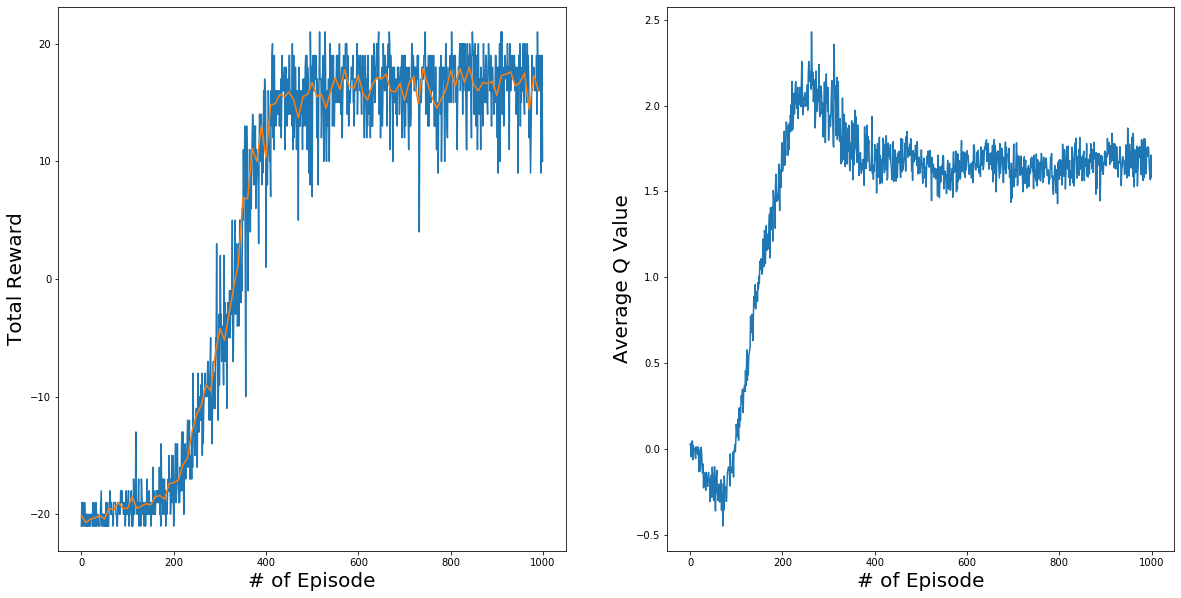

In [6]:
train_hist = np.array(train_hist)

plt.figure(figsize = (20,10))
plt.subplot(121)
plt.plot(train_hist[:,0])
plt.plot(np.arange(0,EPISODE_MAX,10),
         np.array(train_hist[:,0]).reshape(-1, 10).mean(axis = 1))
plt.xlabel('# of Episode', fontsize = 20)
plt.ylabel('Total Reward', fontsize = 20)

plt.subplot(122)
plt.plot(train_hist[:,1])

plt.xlabel('# of Episode', fontsize = 20)
plt.ylabel('Average Q Value', fontsize = 20)

plt.savefig('results.png', fmt = 'png', 
            bbox_inches= "tight", pad_inches=0.1)

# Rendering policy

In [7]:
_ = simulate(env, 3000, predict, True)
#_ = simulate(env, 5000, predict, False)

#  Saving Network parameters

In [ ]:
torch.save(Q.state_dict(), 'pong_Q')
torch.save(target_Q.state_dict(), 'pong_Q_target')

# Saving animation

In [8]:
env = gym.make('PongDeterministic-v4')

'''
Q = DQN(env.action_space.n).to(device)
target_Q = DQN(env.action_space.n).to(device)
####### load model ##########

Q.load_state_dict(torch.load('pong_Q_inter'))
target_Q.load_state_dict(torch.load('pong_Q_inter'))
'''

reward_tot, reward, done, t, frames = simulate(env, 3000, predict, True)

In [11]:
from matplotlib import animation
def save_frames_as_gif(frames, path='./', filename='pong_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 200.0, frames[0].shape[0] / 200.0), dpi=144)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=0)
    anim.save(path + filename, writer='imagemagick', fps=12)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


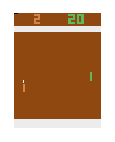

In [12]:
save_frames_as_gif(frames[900::4])

In [9]:
t

1853